In [1]:
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
from slisemap import Slisemap
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import torch
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('/workspace/PlayNet/handball_X_train.csv')
train_y = pd.read_csv('/workspace/PlayNet/handball_y_train.csv')
train_states = train_y.copy()
train_states.head()

#play
0  time_out
1  time_out
2  time_out
3  time_out
4  time_out

In [3]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

train_states['#play'] = labelencoder.fit_transform(train_states['#play'])

# passing bridge-types-cat column (label encoded values of bridge_types)
#enc_df = pd.DataFrame(enc.fit_transform(df[['#play']]).toarray())

In [17]:
X = train.values[:train.shape[0]//16, :]
y = train_states.values[:train_states.shape[0]//16, :]

print(X.shape)

(43898, 66)


/opt/conda/envs/playnet/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


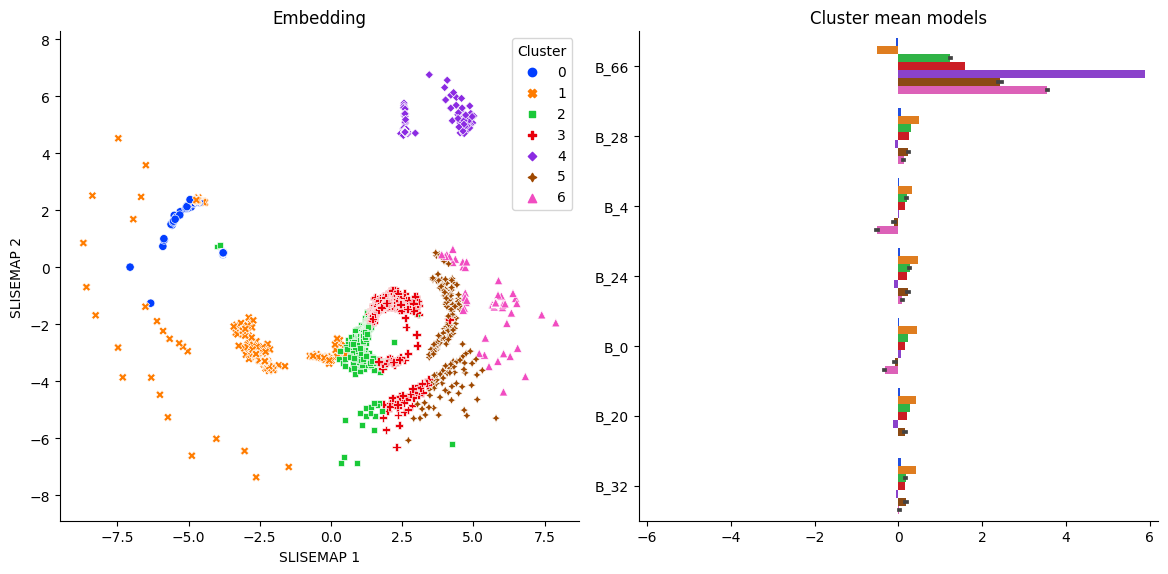

In [18]:
sm = Slisemap(X, y, radius=3.5, lasso=0.01)
sm.optimise()
sm.plot(clusters=7, bars=7)

In [21]:
embeddings = sm.predict()

In [22]:
c = ['k_{0}'.format(s) for s in range(30)]

#train_data = pd.read_csv('embedding.csv', header=None, names=c)

label = 'state'
train_data = pd.DataFrame(embeddings)
train_data[label] = train_y['#play']
print(train_data.head())
print(train_data.describe())

time_limit = 60*60*1
metric = 'accuracy'
predictor = TabularPredictor(label, eval_metric=metric).fit(
    train_data, 
    time_limit=time_limit, 
    presets='medium_quality',
    hyperparameters={'NN':{}, 'GBM':{}, 'RF':{}, 'XT':{}, 'KNN':{}}
)


No path specified. Models will be saved in: "AutogluonModels/ag-20230503_071117/"
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/ag-20230503_071117/"
AutoGluon Version:  0.7.0
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #154-Ubuntu SMP Thu Jan 5 17:03:22 UTC 2023
Train Data Rows:    43898
Train Data Columns: 1
Label Column: state
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	7 unique label values:  ['time_out', 'left_transition', 'left_attack', 'right_transition', 'right_attack', 'left_penal', 'right_penal']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 7
Using Feature Generators to pre

          0     state
0  5.868083  time_out
1  5.894913  time_out
2  5.896235  time_out
3  5.895417  time_out
4  5.890338  time_out
                  0
count  43898.000000
mean       2.269208
std        1.764726
min       -0.049254
25%        0.038051
50%        2.890772
75%        3.054292
max        5.932406


	0.9864	 = Validation score   (accuracy)
	168.21s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForest ... Training model for up to 3431.67s of the 3431.66s of remaining time.
	0.9876	 = Validation score   (accuracy)
	1.52s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: ExtraTrees ... Training model for up to 3430.03s of the 3430.02s of remaining time.
	0.9892	 = Validation score   (accuracy)
	1.09s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetMXNet ... Training model for up to 3428.78s of the 3428.78s of remaining time.
		Unable to import dependency mxnet. A quick tip is to install via `pip install mxnet --upgrade`, or `pip install mxnet_cu101 --upgrade`
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 3428.77s of remaining time.
	0.992	 = Validation score   (accuracy)
	0.24s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 171.49s ... Be

In [29]:

#test_data = pd.read_csv('embedding_test.csv', header=None, names=c)
#test_data_umap = pd.read_csv('embedding_test_u.csv', header=None, names=c)

test = pd.read_csv('/workspace/PlayNet/handball_X_test.csv')
y_test = pd.read_csv('/workspace/PlayNet/handball_y_test.csv')['#play']

#X = train.values[:train.shape[0], :]
#y = train_states.values[:train_states.shape[0], :]

print(len(test) / (train.shape[0]//16))

# split dataframe into chunks
chunks = np.array_split(test, len(test) // (train.shape[0]//16))

# process each chunk
for chunk in chunks:
    test_data_slise = sm.predict(chunk.values, B=sm.get_B())

y_pred = predictor.predict(pd.DataFrame(test_data_ivis))
#y_test = TabularDataset('y_pred_test.csv')

perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True, detailed_report=True)

test_df = pd.DataFrame(test_data_ivis)
test_df['state'] = y_test
lead = predictor.leaderboard(test_df, extra_info=True, extra_metrics=['accuracy', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted', 'f1_macro', 'f1_weighted'], silent=True)

lead.to_csv('lead.csv', index=False)

6.857305572007836


SlisemapException: AssertionError, Slisemap.predict: X and B must have the same number of rows: 50171 != 43898

In [ ]:
print('\\midrule')

first = True
for m in predictor.get_model_names():
    #print(m)
    y_pred = predictor.predict(pd.DataFrame(test_data_ivis), model=m)

    perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True, detailed_report=True, silent=True)

    if first:
        print('\\multirow{6}{*}{IVIS  \cite{szubert2019structure}} & ' 
            + m + ' & ' 
            + "{:.1f}".format(round(perf['classification_report']['accuracy']*100,1)) + '\\%  & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['precision']*100,1)) +'\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['precision']*100,1)) +'\\% & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['recall']*100,1)) + '\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['recall']*100,1)) + '\\%  & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['f1-score']*100,1)) + '\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['f1-score']*100,1)) + '\\% \\\\')
        first = False
    else:
        print('& ' + m + ' & ' 
            + "{:.1f}".format(round(perf['classification_report']['accuracy']*100,1)) + '\\%  & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['precision']*100,1)) +'\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['precision']*100,1)) +'\\% & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['recall']*100,1)) + '\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['recall']*100,1)) + '\\%  & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['f1-score']*100,1)) + '\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['f1-score']*100,1)) + '\\% \\\\')


In [ ]:
print(perf)